<a href="https://colab.research.google.com/github/Mahender-224/Data-Science-Assignments/blob/main/NLP/Named_Entity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

In [ ]:
# Hyperparameter if GPU is available
if tf.test.is_gpu_available():
  BATCH_SIZE = 512
  EPOCHS = 5
  MAX_LEN = 75
  EMBEDDING = 40
else:
  BATCH_SIZE = 32
  EPOCHS = 5
  MAX_LEN = 75
  EMBEDDING = 20

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [ ]:
# Reading the data
!gdown 1ao5aINQqedAWHSXGLpAVzW1iEZj7sZ5_
!gdown 15RuVEDqO592th-44iVEpcGbtvX9RjDWR

Downloading...
From: https://drive.google.com/uc?id=1ao5aINQqedAWHSXGLpAVzW1iEZj7sZ5_
To: /content/ner_dataset.csv
100% 15.2M/15.2M [00:00<00:00, 69.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=15RuVEDqO592th-44iVEpcGbtvX9RjDWR
To: /content/drugsComTrain_raw.csv
100% 1.38M/1.38M [00:00<00:00, 93.8MB/s]


In [ ]:
data = pd.read_csv("/content/ner_dataset.csv", encoding = "latin1")

data.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In column sentence # sentence1 is followed by NaN, so let's fill the same with the value at top

In [ ]:
data = data.fillna(method="ffill")

data.head(n= 24)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


As we have 4 columns
1.Sentence #
2. Word
3. POS
4. Tag(the annotation which is manually labelled against each word)

The method of labelling is known as sequence labelling. Let's take a look at some of the numbers.

In [ ]:
data.shape

(1048575, 4)

In [ ]:
print("Number of sentences: ", len(data.groupby("Sentence #")))

Number of sentences:  47959


In [ ]:
words = list(set(data["Word"].values))

n_words = len(words)
print("Number of unique words in the dataset: ", n_words)

Number of unique words in the dataset:  35178


Number of words are less then number of sentence. Its bcuz we can have some word in different sentences.

In [ ]:
n_tags = len(data.groupby("Tag"))
print("Number of Labels: ", n_tags)

Number of Labels:  17


In [ ]:
tags = list(set(data["Tag"].values))
print("Tags: ", tags)

Tags:  ['I-org', 'B-tim', 'I-tim', 'O', 'I-art', 'B-eve', 'B-gpe', 'B-per', 'B-org', 'I-eve', 'I-gpe', 'I-nat', 'B-art', 'B-nat', 'I-geo', 'B-geo', 'I-per']


geo = Geographical Entity
org = Organization
per = Person
gpe = Geopolitical Entity
tim = Time Indicator
art = Artifact
eve = Event
nat = Natural Phenomenon

In [ ]:
# Lets check the frequency of each tag
data["Tag"].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

Wre can see there is imbalance in data

**Pre_Processing**

For preprocessing we will first put each sentence through a function which will put each of the words along its POS and Tag together in a tuple. Each sentence will form a list of tuples.

In [ ]:
class SentenceGetter(object):
  """ Class to get the text in this format:
  [(Token_1, parts_of_speech, Tag_1), ....., ]"""
  def __init__(self, data):
    self.n_sent = 1
    self.data = data
    self.empty = False
    agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                       s["POS"].values.tolist(),
                                                       s["Tag"].values.tolist())]
    self.grouped = self.data.groupby("Sentence #").apply(agg_func)
    self.sentences = [s for s in self.grouped]

  def get_next(self):
    try:
      s = self.grouped["Sentence: {}".format(self.n_sent)]
      self.n_sent += 1
      return s
    except:
      return None

getter = SentenceGetter(data)
sent = getter.get_next()
print("This is what a sentence looks like:")
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


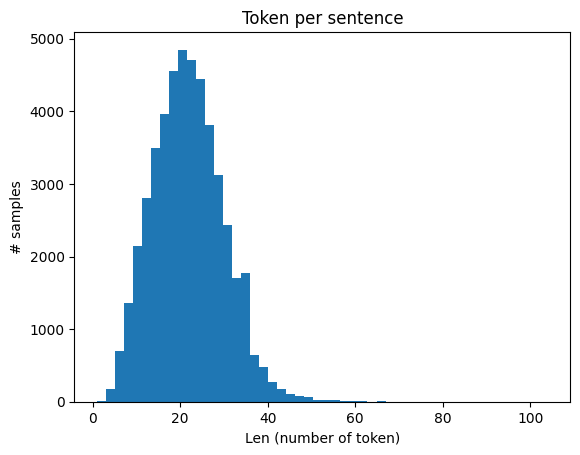

In [ ]:
# get all the sentences
sentences = getter.sentences
# plot the sentences by length
plt.hist([len(s) for s in sentences], bins = 50)
plt.title("Token per sentence")
plt.xlabel("Len (number of token)")
plt.ylabel("# samples")
plt.show()

From above we can see that most of the sentences are of length 15-30

**Futher PreProcessing**

1. We will convert each word to corresponding integer ID using the word2idx dictionary. Doing so saves lots of memory
2. Inorder to feed the data into Bi-LSTM-CRF model, we need to ensure that all text should be of same length.
  1. The method sequence.pad_sequences() and variable MAX_LEN are used for this purpose.
  2. The text which are shorter then MAX_LEN are padded with 0 and text which are longer then MAX_LEN are truncated

In [ ]:
import sklearn

# Vocabulary key:word -> value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i+2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
print("The word Obama is identified by index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geographical Entities) is identified by the index: {}".format(tag2idx["B-geo"]))

The word Obama is identified by index: 13633
The labels B-geo(which defines Geographical Entities) is identified by the index: 16


In [ ]:
from keras.utils import pad_sequences

# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]

# pad each sentences to have same length
X = pad_sequences(maxlen= MAX_LEN, sequences = X, padding = "post", value = word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]

# Padding te sentences to have same length
y = pad_sequences(maxlen=MAX_LEN, sequences = y, padding = "post", value = tag2idx["PAD"])

from keras.utils import to_categorical

# One hot encoding
y = [to_categorical(i, num_classes = n_tags + 1) for i in y]

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size = 0.1)

X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape
print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [11485  3814  8851 11730  4717  4073 28776 29572 19578  3915 15182 22292
 28412 34927   357  3915 34693  3814  4497 17846 30216 32889 30680 25016
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
X_tr = X_tr.astype(int)

**Model Building - Bi-LSTM + CRF**

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 15.1 MB/s eta 0:00:00


In [ ]:
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow_addons.layers import CRF

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
# Model definition
input = Input(shape = (MAX_LEN, ))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
# Above units refers to output dimensions and the o/p from forward and backward are concatenated and sent to dense layer

model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNetwork

crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 75)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 75, 20)            703600    
                                                                 
 bidirectional_2 (Bidirectio  (None, 75, 100)          28400     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 75, 50)           5050      
 tributed)                                                       
                                                                 
 crf_2 (CRF)                 [(None, 75),              1278      
                              (None, 75, 18),                    
                              (None,),                     

In [ ]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,validation_split=0.1, verbose=2)

Epoch 1/5


TypeError: ignored

In [ ]:
# See Medium post by Kumar Utkarsh

Now let us try to use a pharma dataset and do the tagging

We need to find the relation between drug name and problems it is causing.

Note: Here for this data we don't the labelling pre-defined, now how can we train model?

In [ ]:
raw_df = pd.read_csv("/content/drugsComTrain_raw.csv", encoding = "iso-8859-1")
raw_df.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461.0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,20-May-12,27.0
1,95260.0,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,27-Apr-10,192.0
2,92703.0,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,14-Dec-09,17.0
3,138000.0,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,03-Nov-15,10.0
4,35696.0,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,27-Nov-16,37.0


We can see the dataset has important columns
1. drugName
2. condition
3. review

Let's take a look at one of the review and understand how a SME would have labelled it manually

In [ ]:
print("Review Number: ", raw_df["uniqueID"][0])
print("Drug Name: ", raw_df["drugName"][0])
print("Review: ", raw_df["review"][0])

Review Number:  206461.0
Drug Name:  Valsartan
Review:  "It has no side effect, I take it in combination of Bystolic 5 Mg and Fish Oil"


From above we can see that there is no side effects causing for Valsartan drug. Let's look a another row

In [ ]:
print("Review Number: ", raw_df["uniqueID"][15])
print("Drug Name: ", raw_df["drugName"][15])
print("Review: ", raw_df["review"][15])

Review Number:  81890.0
Drug Name:  Liraglutide
Review:  "I have been taking Saxenda since July 2016.  I had severe nausea for about a month once I got up to the 2.6 dosage.  It has since subsided and the only side effect I notice now is the dry mouth.  I make sure to drink  2.5 litres of water a day (about 10 glasses).  This helps with the weight loss as well as the constipation.  I have been reducing my dose to find a comfortable spot where I am still losing weight but don&#039;t feel like I am over medicating.  For me, 1.8 is working very well.  I also feel wearing a Fitbit has really helped.  I can track my food, water, exercise and steps - it keeps me moving more.  When this started I could barely walk the length of myself without getting winded - I have lost 58 lbs so far."


Liraglutide causes side effects as nausea and dry mouth

So here we need to map to the Liraglutide with dry mouth and nausea

But how?

Let's check what are the tools that are in out hands. But before that let's check the word cloud on this review column.

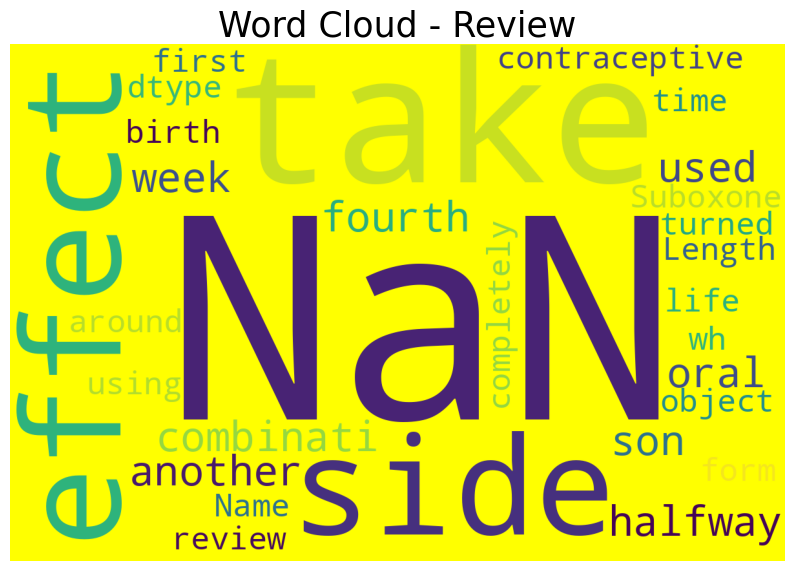

In [ ]:
# Let us see the words cloud for the reviews

# most popular drugs

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopwords = set(STOPWORDS)

wordcloud = WordCloud(background_color='yellow', stopwords = stopwords, width = 1200, height = 800).generate(str(raw_df['review']))

plt.rcParams['figure.figsize'] = (10, 15)
plt.title('Word Cloud - Review', fontsize = 25)
print(wordcloud)
plt.axis("off")
plt.imshow(wordcloud)
plt.show()

We don't get any much information from the word cloud

Now we need a model which is pre-trained on Bio_medical data and would be able to identify drug names and side-affects/symptoms and disease names.

One of such pre-trained model is Stanza
**Bio-Medical NER - Stanza**

In [ ]:
# lets download stanza
!pip install stanza

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.5/802.5 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 kB 24.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=5efb8355a0d4fcb26aa0e29839f1c7a05073c467630b4f904bd8ff24ced06bc8
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji


In [ ]:
import stanza
stanza.download('en', package='mimic', processors = {'ner': 'i2b2'})
stanza.download('en', package='mimic', processors = {'ner': 'bc5cdr'})

INFO:stanza:Downloading these customized packages for language: en (English)...
| Processor       | Package |
-----------------------------
| tokenize        | mimic   |
| pos             | mimic   |
| lemma           | mimic   |
| depparse        | mimic   |
| ner             | i2b2    |
| pretrain        | mimic   |
| backward_charlm | mimic   |
| forward_charlm  | mimic   |



INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


INFO:stanza:Downloading these customized packages for language: en (English)...
| Processor       | Package |
-----------------------------
| tokenize        | mimic   |
| pos             | mimic   |
| lemma           | mimic   |
| depparse        | mimic   |
| ner             | bc5cdr  |
| backward_charlm | pubmed  |
| forward_charlm  | pubmed  |
| pretrain        | craft   |
| backward_charlm | mimic   |
| forward_charlm  | mimic   |
| pretrain        | mimic   |

INFO:stanza:File exists: /root/stanza_resources/en/tokenize/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/pos/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/lemma/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/depparse/mimic.pt


INFO:stanza:File exists: /root/stanza_resources/en/backward_charlm/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/forward_charlm/mimic.pt
INFO:stanza:File exists: /root/stanza_resources/en/pretrain/mimic.pt
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.


As we have drug-name in the data, we need Problem and Disease entity identifier only, we are downloading only 2 entity models

1. i2b2
2. bc5cdr


Now let's create two pipeline with these

In [ ]:
nlp1 = stanza.Pipeline('en', package = 'mimic', processors = {'ner':'i2b2'})
nlp2 = stanza.Pipeline('en', package = 'mimic', processors = {'ner':'bc5cdr'})

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | mimic   |
| pos       | mimic   |
| lemma     | mimic   |
| depparse  | mimic   |
| ner       | i2b2    |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | mimic   |
| pos       | mimic   |
| lemma     | mimic   |
| depparse  | mimic   |
| ner       | bc5cdr  |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [ ]:
doc = nlp1("This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my period longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps.")

doc.entities

[{
   "text": "birth control",
   "type": "TREATMENT",
   "start_char": 40,
   "end_char": 53
 },
 {
   "text": "the patch",
   "type": "TREATMENT",
   "start_char": 81,
   "end_char": 90
 },
 {
   "text": "my cramps",
   "type": "PROBLEM",
   "start_char": 304,
   "end_char": 313
 },
 {
   "text": "cramps",
   "type": "PROBLEM",
   "start_char": 371,
   "end_char": 377
 }]

In [ ]:
doc = nlp2("This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my period longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps.")

doc.entities

[{
   "text": "cramps",
   "type": "DISEASE",
   "start_char": 307,
   "end_char": 313
 },
 {
   "text": "cramps",
   "type": "DISEASE",
   "start_char": 371,
   "end_char": 377
 }]

From the above the entities are almost correct but some times it will be not case so chaning entities manually will not take much time.

In [ ]:
# Slicing the first 50 rows while keeping the time factor in mind

df = raw_df.head(50)
df["Side-Effects"] = ""

for i, row in df.iterrows():
  doc = nlp2(row["review"])
  doc_entity = doc.entities

  ae = []

  for token in doc_entity:
    if token.type == "DISEASE":
      ae.append(token.text)
  df.at[i, 'Side-Effects'] = ae

<ipython-input-49-5d0e1965e731>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Side-Effects"] = ""


In [ ]:
df.head(10)

,uniqueID,drugName,condition,review,rating,date,usefulCount,Side-Effects
0,206461.0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,20-May-12,27.0,[]
1,95260.0,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,27-Apr-10,192.0,[]
2,92703.0,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,14-Dec-09,17.0,[]
3,138000.0,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,03-Nov-15,10.0,"[cramps, cramps]"
4,35696.0,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,27-Nov-16,37.0,[constipation]


Now disease column has picked a lot of symptoms/side-effects. Let's put them together

In [ ]:
# Keep only the relevant cols and rows with non-empty side-effects
cols_rel = ['drugName', 'Side-Effects']
df_rel = df.loc[:, cols_rel]
df_rel = df_rel[df_rel["Side-Effects"].astype(bool)]
df_rel.head()

,drugName,Side-Effects
3,Ortho Evra,"[cramps, cramps]"
4,Buprenorphine / naloxone,[constipation]
5,Cialis,[headache]
7,Aripiprazole,"[depression, depressed, Bi-polar disorder]"
9,Ethinyl estradiol / levonorgestrel,"[acne, acne, depression, weight gain, depressed]"


In [ ]:
# create a list to host each problem with the drugname
list = []
for i, row in df_rel.iterrows():
  for ele in enumerate(row["Side-Effects"]):
    list.append((row["drugName"], ele[1]))

In [ ]:
# Convert the list into a dataframe
df_drug_problem = pd.DataFrame(list, columns = ['drugName', 'Side-Effects'])
df_drug_problem.head()

,drugName,Side-Effects
0,Ortho Evra,cramps
1,Ortho Evra,cramps
2,Buprenorphine / naloxone,constipation
3,Cialis,headache
4,Aripiprazole,depression


In [ ]:
df_drug_problem['drugName'].value_counts()

Lamotrigine                           8
Trazodone                             8
Tamsulosin                            7
Dulcolax                              6
Amitriptyline                         6
Ethinyl estradiol / levonorgestrel    5
Ledipasvir / sofosbuvir               5
Dextromethorphan                      5
Azithromycin                          4
Toradol                               4
Pentasa                               4
Liraglutide                           4
Atripla                               3
Trimethoprim                          3
Sertraline                            3
Contrave                              3
Topiramate                            3
Aripiprazole                          3
Imitrex                               3
Fluconazole                           2
Trilafon                              2
MoviPrep                              2
Ortho Evra                            2
Daytrana                              2
L-methylfolate                        2


We can see the top 5 drugNames with highest number of side-effects are:

Lamotrigine
Trazodone
Tamsulosin
Dulcolax
Amitriptyline

**Scope for Improvement**

1. Use BIO-Bert Relationship extraction: we can see that some of the problems are solved by that Drug as well, so if we can establish a relationship b/w the drugname and side effect that will give us the much refined insight about the drug

2. Knowledge Graph for Questioning and Answering purpose

After labelling with the stanza try to build the model with the Bi-LSTM + CRF or any other combination